In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Import matplotlib for visualization
import matplotlib.pyplot as plt

import requests
from pathlib import Path 

from helper_functions import accuracy_fn

from timeit import default_timer as timer

from tqdm.auto import tqdm, trange

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.9.0+cu102
torchvision version: 0.10.0+cu102


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [3]:
train_data = datasets.FashionMNIST(
    root="/home/pocmst/Development/datasets/torch",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="/home/pocmst/Development/datasets/torch",
    train=False,
    download=True,
    transform=ToTensor()
)

/home/pocmst/Development/pyenv/antispoof-demo/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
BATCH_SIZE = 32
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fa709e09a90>, <torch.utils.data.dataloader.DataLoader object at 0x7fa7e90d1e80>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [5]:
class FashionMNISTV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [6]:
model_0 = FashionMNISTV1(input_shape=784, hidden_units=10, output_shape=len(train_data.classes))
model_0.to(device)

FashionMNISTV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [8]:
def print_train_time(start, end, device=None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [9]:
torch.manual_seed(42)

epochs = 3
train_time_start_on_cpu = timer()

for epoch in trange(epochs):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        
        X = X.to(device)
        y = y.to(device)
        
        # 1 forward pass
        y_pred = model_0(X)
        
        # 2 calculate loss per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss
        
        # 3 optimizer zero grad
        optimizer.zero_grad()
        
        # 4 loss backward
        loss.backward()
        
        # 5 optimizer step
        optimizer.step()
        
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
            
    train_loss /= len(train_dataloader)
    
    test_loss, test_acc = 0, 0
    model_0.eval()
    
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            
            # 1. Forward pass
            test_pred = model_0(X)
            
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y)
            
            # 3. calculate accuracy
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)
        
        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)
    
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.58534 | Test loss: 0.50573, Test acc: 82.22%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47586 | Test loss: 0.48784, Test acc: 82.83%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45473 | Test loss: 0.47715, Test acc: 83.37%

Train time on cuda:0: 22.444 seconds


In [10]:
class FashionMNISTV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [11]:
torch.manual_seed(42)

model_1 = FashionMNISTV1(input_shape=784, hidden_units=10, output_shape=len(train_data.classes)).to(device)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [13]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(data_loader):
        # send to gpu jika ada
        X, y = X.to(device), y.to(device)
        
        # 1. forward pass
        y_pred = model(X)
        
        # 2. calculate loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # 3. optimizer zerograd
        optimizer.zero_grad()
        
        # 4. loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    
def test_step(data_loader, model, loss_fn, accuracy_fn, device):
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for X, y in data_loader:
            # send to gpu jika ada
            X, y = X.to(device), y.to(device)
            
            # 1. forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
            
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        
def eval_model(model, data_loader, loss_fn, accuracy_fn, device):
    loss, acc = 0, 0
    model.eval()
    
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1))
            
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [14]:
torch.manual_seed(42)

train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_step(
        model=model_1,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    
    test_step(
        data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )
    
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.95637 | Test accuracy: 65.00%

Epoch: 1
---------
Train loss: 0.78101 | Train accuracy: 71.93%
Test loss: 0.72227 | Test accuracy: 73.91%

Epoch: 2
---------
Train loss: 0.67027 | Train accuracy: 75.94%
Test loss: 0.68500 | Test accuracy: 75.02%

Train time on cuda: 22.438 seconds


In [15]:
class FashionMNISTV2(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [16]:
torch.manual_seed(42)
model_2 = FashionMNISTV2(input_shape=1, hidden_units=10, output_shape=len(train_data.classes)).to(device)
model_2

FashionMNISTV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

In [18]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------


/home/pocmst/Development/pyenv/antispoof-demo/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train loss: 0.59174 | Train accuracy: 78.65%
Test loss: 0.40400 | Test accuracy: 85.66%

Epoch: 1
---------
Train loss: 0.36204 | Train accuracy: 87.06%
Test loss: 0.34727 | Test accuracy: 87.38%

Epoch: 2
---------
Train loss: 0.32403 | Train accuracy: 88.20%
Test loss: 0.32121 | Test accuracy: 88.22%

Train time on cuda: 27.462 seconds


In [19]:
model_0_results = eval_model(
    model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_0_results

{'model_name': 'FashionMNISTV1',
 'model_loss': 0.47714856266975403,
 'model_acc': 83.36661341853035}

In [20]:
model_1_results = eval_model(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTV1',
 'model_loss': 0.6850008368492126,
 'model_acc': 75.01996805111821}

In [22]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_2_results

{'model_name': 'FashionMNISTV2',
 'model_loss': 0.3212146461009979,
 'model_acc': 88.21884984025559}

In [23]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTV1,0.477149,83.366613
1,FashionMNISTV1,0.685001,75.019968
2,FashionMNISTV2,0.321215,88.218850


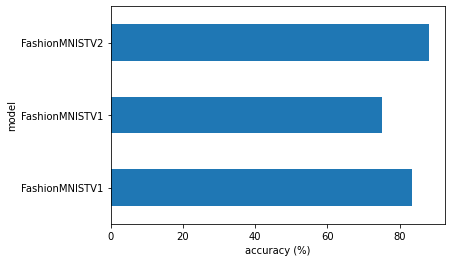

In [24]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

In [25]:
def make_predictions(model, data, device):
    pred_probs = []
    model.eval()
    
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            # forward pass
            pred_logit =  model(sample)
            
            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            
            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)

In [27]:
import random
random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
    
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({test_data.classes[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [34]:
pred_probs = make_predictions(model=model_2, data=test_samples, device=device)
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 6, 4, 7, 1])

In [35]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 6, 4, 7, 1]))

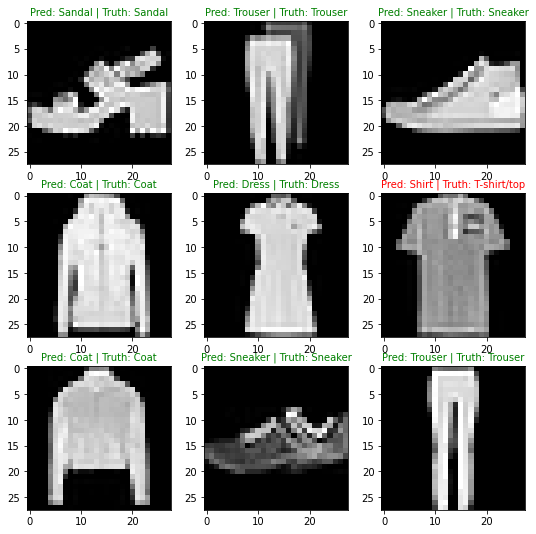

In [45]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = test_data.classes[pred_classes[i]]
    truth_label = test_data.classes[test_labels[i]]
    
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    

In [46]:
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
        
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [47]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.19.0


In [48]:
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.19.0


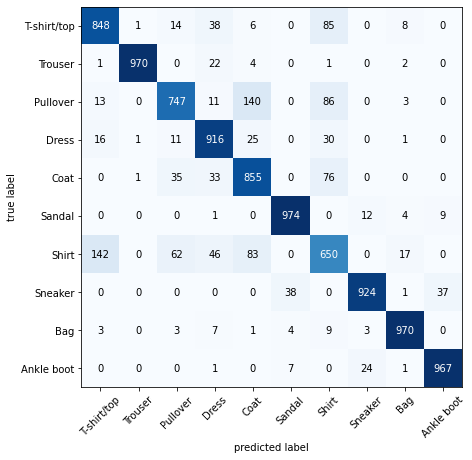

In [52]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(train_data.classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=train_data.classes, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [53]:
from pathlib import Path

In [54]:
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [56]:
loaded_model_2 = FashionMNISTV2(input_shape=1, 
                                    hidden_units=10, # try changing this to 128 and seeing what happens 
                                    output_shape=10) 

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

In [58]:
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn,
    device=device
)

loaded_model_2_results

{'model_name': 'FashionMNISTV2',
 'model_loss': 0.3212146461009979,
 'model_acc': 88.21884984025559}